# Train a NN potential model
We briefly demonstrate in this notebook how the QM9star dataset can be used to train a graph neural network model capable of predicting the potential energy of a non-neutral molecular system. In theory, the model could also be used to learn other global features.

## Requirements
In order to run the notebook, you need to install additional dependencies.
```bash
poetry install -E dl
```
If you have problems configuring your environment, please refer to the README for solutions!

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from nff.train import Adam, Trainer, hooks, loss, metrics
from pint import UnitRegistry
from rdkit import Chem
from sqlmodel import col, select
from sqlmodel.sql.expression import SelectOfScalar
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from qm9star_query.dataset.base_dataset import BaseQM9starDataset
from qm9star_query.models import Snapshot
from qm9star_query.nn.dimenetpp import DimeNetPPCM

ureg = UnitRegistry()
hartree2kcal = ureg.convert(1, "hartree/particle", "kcal/mol")
hartree_bohr2kcal_mol_angstrom = ureg.convert(
    1, "hartree/bohr/particle", "kcal/mol/angstrom"
)
# energy from /tutorial/atom_ref
atom_single_point_energy = {
    "H": -0.5021559 * hartree2kcal,
    "C": -37.7375894 * hartree2kcal,
    "N": -54.4992609 * hartree2kcal,
    "O": -74.9889063 * hartree2kcal,
    "F": -99.7605802 * hartree2kcal,
}


def get_total_atom_energy(atom_list: list[int]):
    res = 0
    for atom in atom_list:
        res += atom_single_point_energy[Chem.Atom(atom).GetSymbol()]
    return res


device = "cuda:0" if torch.cuda.is_available() else "cpu"


def transform_data(raw_data):
    pos = torch.tensor(raw_data["coords"], dtype=torch.float32)
    z = torch.tensor(raw_data["atoms"], dtype=torch.int64)
    energy = torch.tensor(
        raw_data["single_point_energy"] * hartree2kcal
        - get_total_atom_energy(raw_data["atoms"]),
        dtype=torch.float32,
    )
    return Data(
        pos=pos,
        z=z,
        bonds=torch.tensor(raw_data["bonds"], dtype=torch.int64),
        nxyz=torch.concat([z.view(-1, 1), pos], dim=-1),
        formal_charges=torch.tensor(
            raw_data["formal_charges"], dtype=torch.int64),
        formal_num_radicals=torch.tensor(
            raw_data["formal_num_radicals"], dtype=torch.int64
        ),
        energy=energy,
        energy_grad=-torch.tensor(raw_data["forces"], dtype=torch.float32)
        * hartree_bohr2kcal_mol_angstrom,
        id=torch.tensor(raw_data["id"], dtype=torch.int64),
    )

## Data preparation
We provide the data split used for training with train:valid:test = 8:1:1. Executing the following code automatically downloads and preprocesses the data from the deployed QM9star dataset. Depending on the network speed it may take about 2h, in the meantime you can enjoy your coffee break first.

In [2]:
scheme = "postgresql+psycopg2"
POSTGRES_USER = "hxchem"
POSTGRES_PASSWD = "hxchem"
POSTGRES_SERVER = "127.0.0.1"  # actual server address
POSTGRES_PORT = 35432  # actual port
POSTGRES_DB = "qm9star"

In [3]:
if os.path.exists("data_split"):
    trainset_ids = torch.load("data_split/trainset_ids.pt")
    valset_ids = torch.load("data_split/validset_ids.pt")
    testset_ids = torch.load("data_split/testset_ids.pt")

    def select_train(
        selector=select(Snapshot),
    ) -> SelectOfScalar[int] | SelectOfScalar[Snapshot]:
        return selector.where(col(Snapshot.id).in_(np.array(trainset_ids).tolist()))

    def select_val(
        selector=select(Snapshot),
    ) -> SelectOfScalar[int] | SelectOfScalar[Snapshot]:
        return selector.where(col(Snapshot.id).in_(np.array(valset_ids).tolist()))

    def select_test(
        selector=select(Snapshot),
    ) -> SelectOfScalar[int] | SelectOfScalar[Snapshot]:
        return selector.where(col(Snapshot.id).in_(np.array(testset_ids).tolist()))

    train_dataset = BaseQM9starDataset(
        user=POSTGRES_USER,
        password=POSTGRES_PASSWD,
        server=POSTGRES_SERVER,
        port=POSTGRES_PORT,
        db=POSTGRES_DB,
        dataset_name="qm9star_all_train",
        block_num=5,
        log=True,
        transform=transform_data,
        selector_func=select_train,
    )

    valid_dataset = BaseQM9starDataset(
        user=POSTGRES_USER,
        password=POSTGRES_PASSWD,
        server=POSTGRES_SERVER,
        port=POSTGRES_PORT,
        db=POSTGRES_DB,
        dataset_name="qm9star_all_valid",
        block_num=5,
        log=True,
        transform=transform_data,
        selector_func=select_val,
    )

    test_dataset = BaseQM9starDataset(
        user=POSTGRES_USER,
        password=POSTGRES_PASSWD,
        server=POSTGRES_SERVER,
        port=POSTGRES_PORT,
        db=POSTGRES_DB,
        dataset_name="qm9star_all_test",
        block_num=5,
        log=True,
        transform=transform_data,
        selector_func=select_test,
    )
    print(
        f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, test: {len(test_dataset)}"
    )

else:
    total_dataset = BaseQM9starDataset(
        user=POSTGRES_USER,
        password=POSTGRES_PASSWD,
        server=POSTGRES_SERVER,
        port=POSTGRES_PORT,
        db=POSTGRES_DB,
        dataset_name="qm9star_all",
        block_num=5,
        log=True,
        transform=transform_data,
    )
    train_split = 0.8
    val_split = 0.1
    test_split = 0.1

    rng = np.random.default_rng(seed=3407)
    ids = list(total_dataset.indices())
    rng.shuffle(ids)

    train_ids = ids[: int(len(ids) * train_split)]
    val_ids = ids[
        int(len(ids) * train_split) : int(len(ids) * (train_split + val_split))
    ]
    test_ids = ids[int(len(ids) * (train_split + val_split)) :]

    print(f"Train: {len(train_ids)}, Valid: {len(val_ids)}, test: {len(test_ids)}")

    train_dataset = total_dataset[train_ids]
    valid_dataset = total_dataset[val_ids]
    test_dataset = total_dataset[test_ids]
    torch.save(train_dataset.id, "data_split/trainset_ids.pt")
    torch.save(valid_dataset.id, "data_split/validset_ids.pt")
    torch.save(test_dataset.id, "data_split/testset_ids.pt")

Train: 1607044, Valid: 200881, test: 200881


In [4]:
train_loader = DataLoader(
    train_dataset, 192, shuffle=True, follow_batch=["nxyz"])
valid_loader = DataLoader(
    valid_dataset, 192, shuffle=False, follow_batch=["nxyz"])
test_loader = DataLoader(
    test_dataset, 128, shuffle=False, follow_batch=["nxyz"])

## Define model

In [5]:
model = DimeNetPPCM(energy_and_force=False, ret_res_dict=True)
OUTDIR = "./sandbox"

In [6]:
loss_fn = loss.build_mae_loss(loss_coef={"energy": 1})

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)
train_metrics = [
    metrics.MeanAbsoluteError("energy"),
    # metrics.MeanAbsoluteError("energy_grad"),
]
train_hooks = [
    hooks.MaxEpochHook(300),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR, metrics=train_metrics, separator=" | ", time_strf="%M:%S"
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True,
    ),
]
T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=valid_loader,
    checkpoint_interval=1,
    hooks=train_hooks,
)

In [7]:
T.train(device=device, n_epochs=500)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | GPU Memory (MB)


## Result analysis

In [23]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

log = pd.read_csv("sandbox/log.csv")
log["Epoch"] = log.index + 1
log.columns = [
    "Time",
    "Learning Rate",
    "Training Loss",
    "Validation Loss",
    "MAE_energy",
    "Epoch",
]
log

,Time,Learning Rate,Training Loss,Validation Loss,MAE_energy,Epoch
0,977.477456,0.000100,22.182571,5.324299,5.325535,1
1,1754.361884,0.000100,8.263110,7.888897,7.887667,2
2,2525.960714,0.000100,6.168878,5.199538,5.200261,3
3,3297.790652,0.000100,5.235123,3.435690,3.435735,4
4,4067.463570,0.000100,4.596150,3.730829,3.731346,5
...,...,...,...,...,...,...
495,381851.528622,0.000003,0.099040,0.257387,0.257430,496
496,382620.280214,0.000003,0.098934,0.243944,0.243988,497
497,383385.203482,0.000003,0.098846,0.238127,0.238172,498
498,384157.276111,0.000003,0.098954,0.251974,0.252017,499


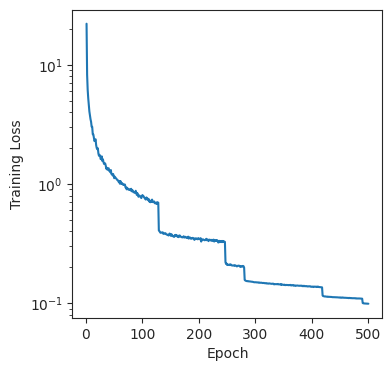

In [24]:
with sns.axes_style("ticks"):
    g = sns.lineplot(data=log, x="Epoch", y="Training Loss")
    g.set_yscale("log")
g.figure.set_size_inches(4, 4)
g.figure.savefig("img/loss.svg", bbox_inches="tight")

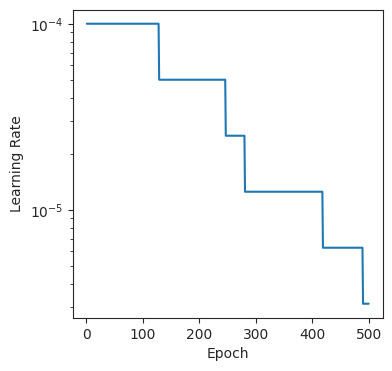

In [25]:
with sns.axes_style("ticks"):
    g = sns.lineplot(data=log, x="Epoch", y="Learning Rate")
    g.set_yscale("log")
g.figure.set_size_inches(4, 4)
g.figure.savefig("img/learning_rate.svg", bbox_inches="tight")

In [11]:
preds = []
observed_values = []
for batch in test_loader:
    observed_values.append(batch.energy.detach_().cpu().double())
    batch = batch.to(device)
    out_res = model(batch)
    out = out_res["energy"].detach_().cpu().double()
    preds.append(out)

/home/tmj/miniconda3/envs/qm9q/lib/python3.10/site-packages/dig/threedgraph/utils/geometric_computing.py:47: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  b = torch.cross(pos_ji, pos_jk).norm(dim=-1) # sin_angle * |pos_ji| * |pos_jk|


In [33]:
pred_value = torch.concat(preds).flatten()
calc_value = torch.concat(observed_values)
result_df = pd.DataFrame(
    {
        "Formation Energy$_{calc}$($\\times10^3$ kcal/mol)": calc_value / 1e3,
        "Formation Energy$_{pred}$($\\times10^3$ kcal/mol)": pred_value / 1e3,
    }
)
result_df["Formation Energy Residual(kcal/mol)"] = pred_value - calc_value

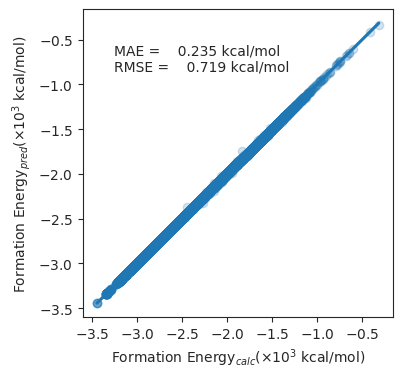

In [29]:
with sns.axes_style("ticks"):
    g = sns.regplot(
        data=result_df,
        x="Formation Energy$_{calc}$($\\times10^3$ kcal/mol)",
        y="Formation Energy$_{pred}$($\\times10^3$ kcal/mol)",
        scatter_kws={"alpha": 0.2},
    )
    g.text(
        0.1,
        0.8,
        f"MAE = {mean_absolute_error(calc_value, pred_value):>8.3f} kcal/mol\nRMSE = {root_mean_squared_error(calc_value, pred_value):>8.3f} kcal/mol",
        transform=g.transAxes,
    )
plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0), useMathText=True)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)
g.figure.set_size_inches(4, 4)
g.figure.savefig("img/reg.svg", bbox_inches="tight")

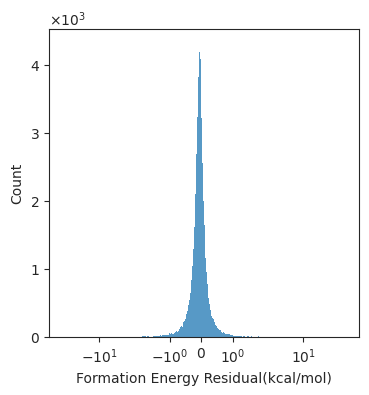

In [47]:
with sns.axes_style("ticks"):
    g = sns.histplot(
        data=result_df,
        x="Formation Energy Residual(kcal/mol)",
    )
    g.set_xscale("symlog")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)
g.figure.set_size_inches(4, 4)
g.figure.savefig("img/resig.svg", bbox_inches="tight")